In [2]:
import pandas as pd
import numpy as np
import file_order_sim
from importlib import reload
reload(file_order_sim)

<module 'file_order' from 'c:\\Users\\robert\\OneDrive\\MSc\\p3.1 - cognitive science\\project\\file_order.py'>

In [3]:
# Parameters
n_scenes = 40
n_subjects = 50
seed = 42

In [4]:
# subjects 

prob_male = 0.7
age = (20, 38)
prob_familiar_football_male = 0.9
prob_familiar_football_female = 0.8

rng = np.random.default_rng(seed)
subjects = range(n_subjects)
ages = rng.uniform(age[0], age[1], n_subjects)
genders = np.array(['f', 'm'])[rng.binomial(1, prob_male, n_subjects)]

knows_football = rng.binomial(1, prob_familiar_football_male, n_subjects)
_pos_f = np.where(genders=='f')
knows_football[_pos_f] = rng.binomial(1, prob_familiar_football_female, len(_pos_f))

sim_success_rate = rng.beta(80, 12, n_subjects)

# let's generate a dataframe for subjects, columns are subject_id, gender, age, knows_football
df_subjects = pd.DataFrame({'subject_id': subjects, 'gender': genders, 'age': ages, 'knows_football': knows_football, 'sim_psucc': sim_success_rate})
df_subjects.head()

,subject_id,gender,age,knows_football,sim_psucc
0,0,m,33.931209,0,0.905365
1,1,m,27.899812,1,0.856320
2,2,f,35.454763,0,0.889489
3,3,m,32.552625,0,0.776397
4,4,f,21.695192,0,0.852277


,scene_id,_sim_scene_penalty
0,0,0.099682
1,1,0.208751
2,2,0.227574
3,3,0.094555
4,4,0.157432


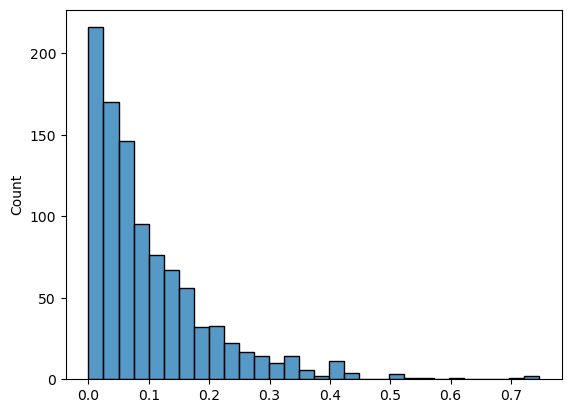

In [5]:
# scenes 

# some scenes are more difficult to answer given the time, grouping, etc
# so each scene will have a penalty on the success rate, following an exponential distribution
SCENE_PENALTY_MEAN = 0.05  # on average a X percent penalty
scene_penalty = rng.exponential(scale=0.1, size=n_scenes)
import seaborn as sns
sns.histplot(rng.exponential(scale=0.1, size=1000), bins=30)

df_scenes = pd.DataFrame({'scene_id': range(n_scenes), '_sim_scene_penalty': scene_penalty})
df_scenes.head()

In [6]:

def generate_data(num_subjects, n_scenes, seed):
    """
    Generate synthetic data for cognitive science experiment.
    """
    data = []

    # Loop over each subject to generate filenames and create data entries
    for subj in range(num_subjects):
        filenames = file_order_sim.generate_file_list(n_scenes, seed + subj)
        for filename in filenames:
            scene_id = int(filename[2:4])
            red_count = int(filename[6:7])
            blue_count = int(filename[9:10])
            
            # Append data
            data.append([subj, filename, scene_id, red_count, blue_count])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['subject_id', 'filename', 'scene_id', 'red_count', 'blue_count'])
    
    # Add expected side
    conditions = [
        df['red_count'] > df['blue_count'],  # Red majority
        df['red_count'] < df['blue_count']   # Blue majority
    ]
    choices = ['red', 'blue']
    df['expected_side'] = np.select(conditions, choices, default='none')
    
    return df

In [7]:
# Generate the dataframe using the functions
df = generate_data(n_subjects, n_scenes, seed)

In [8]:
# add a response time column to the dataframe
# now let's refine the reponse time so that each subject has a sliglty different mean and standard deviation
# the per subject mean is sampled from a normal distribution with mean 1000 and sd 100
# the per subject standard deviation is sampled from a normal distribution with mean 100 and sd 10

subject_mean = np.abs(np.random.normal(1000, 100, size=n_subjects))
subject_std = np.abs(np.random.normal(100, 10, size=n_subjects))
df['response_time'] = df.apply(lambda row: np.abs(np.random.normal(subject_mean[row.subject_id], subject_std[row.subject_id])), axis=1)

## Effects

In [9]:
# main effect - colour influences the correct response rate

# let's say that if the the majority team is red, the subject is 1.2 times more likely to answer correctly than otherwise
# so p_succ_red / p_succ_blue = 1.2, but we know the base success rate _sim_psucc is the average between p_succ_red and p_succ_blue
# So p_succ_red = 2*(sim_psucc - p_succ_blue/2)
# so 2*(sim_psucc - p_succ_blue/2) / p_succ_blue = 1.2
# 2 * sim_psucc/p_succ_blue - 1 = 1.2
# sim_psucc/p_succ_blue = 1.1
# p_succ_blue = sim_psucc / 1.1
# p_succ_red = 1.2 * p_succ_blue

# let's say that one average men are 20% more likely to correctly pick the majority when the majority is red
# but this degree varies, for some men, if be less likely, so the effect size per male subject is N(0.2, _sd_for_negative_pd(0.2))

# using scipy stats to calculate the standard deviation of a normal distribution of mean M such that 20% of the probability mass is bellow 0
def _sd_for_negative_pd(M, prop_bellow_0):
    import scipy.stats as stats
    z = stats.norm.ppf(prop_bellow_0)
    SD = (0 - M) / z
    return SD

male_effect_mean = 0.1
male_effect_sd = _sd_for_negative_pd(male_effect_mean, 0.2)
subject_effects_male = rng.normal(male_effect_mean, male_effect_sd, size=n_subjects)

# # some visualisation
# sns.histplot(rng.normal(male_effect_mean, _sd_for_negative_pd(male_effect_mean, 0.1), size=1000))
# # add a vertical line at 0
# from matplotlib import pyplot as plt
# plt.axvline(0, 0, 1, color='red')

female_effect_mean = 0 
subject_effects_female = rng.normal(female_effect_mean, male_effect_sd*0.5, size=n_subjects)

subject_effects = subject_effects_male
subject_effects[_pos_f] = subject_effects_female[_pos_f]

# subject_effects

# # perform a one sided t-test to check if the mean of subject_effects is greater than 0
# from scipy.stats import ttest_1samp
# ttest_1samp(subject_effects, 0)

## given how much more likely the percentage offset, we can now calculate p_succ_red and p_succ_blue for each subject
#p_succ_blue = df.apply(lambda row: row.sim_psucc / (1 + subject_effects[row.subject_id]/2), axis=1)
p_succ_blue = df_subjects.sim_psucc / (1 + subject_effects[df_subjects.subject_id]/2)
#p_succ_red = df.reset_index().apply(lambda row: (1 + subject_effects[row.subject_id]) * p_succ_blue[row['index']], axis=1)
p_succ_red = (1 + subject_effects[df_subjects.subject_id]) * p_succ_blue

# check that p_succ_blue and p_succ_red have been calculated correctly
assert np.abs((p_succ_red + p_succ_blue) / 2 - df_subjects.sim_psucc).sum() < 1e-14

df_subjects['_sim_psucc_blue'] = p_succ_blue
df_subjects['_sim_psucc_red'] = p_succ_red

<Axes: ylabel='Count'>

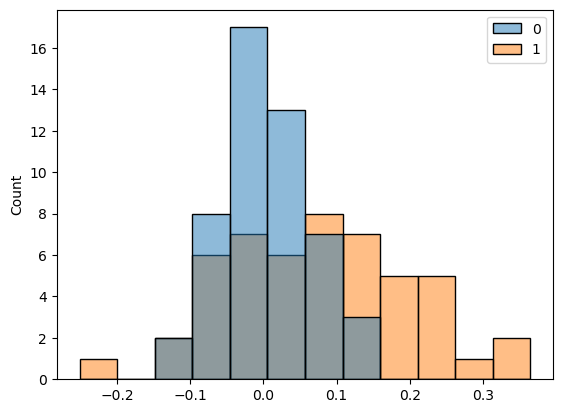

In [21]:
sns.histplot([subject_effects_female, subject_effects_male])

## Final dataframe

In [11]:
# join df with df_subjects and df_scenes
df_merged = df.merge(df_subjects, on='subject_id')
df_merged = df_merged.merge(df_scenes, on='scene_id')
df_merged.head()

,subject_id,filename,scene_id,red_count,blue_count,expected_side,response_time,gender,age,knows_football,sim_psucc,_sim_psucc_blue,_sim_psucc_red,_sim_scene_penalty
0,0,id11_r5_b6.png,11,5,6,blue,744.478167,m,33.931209,0,0.905365,0.964352,0.846378,0.12741
1,0,id11_r6_b5.png,11,6,5,red,736.166809,m,33.931209,0,0.905365,0.964352,0.846378,0.12741
2,1,id11_r5_b6.png,11,5,6,blue,1162.832452,m,27.899812,1,0.856320,0.737801,0.974840,0.12741
3,1,id11_r6_b5.png,11,6,5,red,1026.085795,m,27.899812,1,0.856320,0.737801,0.974840,0.12741
4,2,id11_r6_b5.png,11,6,5,red,1100.398371,f,35.454763,0,0.889489,0.832009,0.946970,0.12741


In [12]:
p_succ_multiplier = df_merged._sim_psucc_red.to_numpy()
_pos_blue = np.where(df_merged['expected_side']=='blue')[0]
p_succ_multiplier[_pos_blue] = df_merged._sim_psucc_blue[_pos_blue]

df_merged['_sim_psucc_multiplier_color'] = p_succ_multiplier

In [13]:
# now applying the scene penalty and the _sim_psucc_multiplier to get the probability of correct answer for each trial
df_merged['sim_psucc'] = df_merged.apply(lambda row: (row.sim_psucc - row._sim_scene_penalty) * row._sim_psucc_multiplier_color, axis=1)

# finally let's provide the answered_side
def _other_side(side):
    return 'red' if side == 'blue' else 'blue'

df_merged['response_side'] = df_merged.apply(lambda row: row.expected_side if rng.binomial(1, row.sim_psucc) else _other_side(row.expected_side), axis=1)
df_merged

,subject_id,filename,scene_id,red_count,blue_count,expected_side,response_time,gender,age,knows_football,sim_psucc,_sim_psucc_blue,_sim_psucc_red,_sim_scene_penalty,_sim_psucc_multiplier_color,response_side
0,0,id11_r5_b6.png,11,5,6,blue,744.478167,m,33.931209,0,0.750222,0.964352,0.964352,0.127410,0.964352,blue
1,0,id11_r6_b5.png,11,6,5,red,736.166809,m,33.931209,0,0.658444,0.964352,0.846378,0.127410,0.846378,red
2,1,id11_r5_b6.png,11,5,6,blue,1162.832452,m,27.899812,1,0.537791,0.737801,0.737801,0.127410,0.737801,red
3,1,id11_r6_b5.png,11,6,5,red,1026.085795,m,27.899812,1,0.710571,0.737801,0.974840,0.127410,0.974840,blue
4,2,id11_r6_b5.png,11,6,5,red,1100.398371,f,35.454763,0,0.721666,0.832009,0.946970,0.127410,0.946970,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,47,id03_r6_b5.png,3,6,5,red,1292.677175,m,25.189906,1,0.673152,0.786889,0.899292,0.094555,0.899292,red
2996,48,id03_r6_b5.png,3,6,5,red,873.686146,m,32.284919,1,0.698560,0.929157,0.868539,0.094555,0.868539,blue
2997,48,id03_r5_b6.png,3,5,6,blue,1050.163127,m,32.284919,1,0.747314,0.929157,0.929157,0.094555,0.929157,blue
2998,49,id03_r5_b6.png,3,5,6,blue,714.653247,f,22.515545,0,0.673287,0.884182,0.884182,0.094555,0.884182,blue


In [14]:
# if the expeted side is blue the response time increases by aprox 10%. The actual increase value is normal around 10% with std of 1%
df_merged['response_time'] = df_merged.apply(lambda row: row.response_time * np.random.normal(1.1, 0.01) if row.expected_side == 'blue' else row.response_time, axis=1)

In [15]:
# add a column so that each scene has a response_time factor uniformly sampled between 0.8 and 1.2
df_merged['response_time'] = df_merged.apply(lambda row: row.response_time * np.random.uniform(0.8, 1.2), axis=1)

In [16]:
# round the age to full years
df_merged['age'] = df_merged.age.apply(lambda x: int(x))

In [17]:
# save two versions of the dataframe one with ground truth, one without
df_merged.drop(columns = [col for col in df_merged.columns if col not in ['subject_id', 'filename', 'gender', 'age', 'knows_football', 'response_time', 'response_side']]).to_csv('synthetic.csv', index=None)

df_merged.drop(columns = [col for col in df_merged.columns if col not in ['subject_id', 'filename', 'gender', 'age', 'knows_football', 'response_time', 'response_side', 'sim_psucc']]).to_csv('synthetic_gt.csv', index=None)

df_merged.to_csv('synthetic_full.csv', index=None)
